In [1]:
!pip install transformers


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Optional - Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Reading the data

In [14]:
df = pd.read_csv("/content/training_data_lowercase.csv", sep ='\t',header=None, names=['label', 'text'] )
df = df[['text', 'label']]
df

,text,label
0,donald trump sends out embarrassing new year‚s...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama‚s name ...,0
4,pope francis just called out donald trump duri...,0
...,...,...
34147,tears in rain as thais gather for late king's ...,1
34148,pyongyang university needs non-u.s. teachers a...,1
34149,philippine president duterte to visit japan ah...,1
34150,japan's abe may have won election\tbut many do...,1


#Get BERT Embeddings

In [15]:

import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import numpy as np


In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.eval()  # Set to evaluation mode


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [17]:
texts = list(df['text'])  # Replace with your column name
batch_size = 16
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids']
        attention_mask = encoded['attention_mask']

        # Get model output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.extend(cls_embeddings.numpy())


100%|██████████| 2135/2135 [01:55<00:00, 18.49it/s]


In [18]:
X = np.array(all_embeddings)  # Shape: (num_samples, 768)


#Train a Classifier

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# X: Embeddings from BERT
# y: Your label column
y = df['label'].values  # Make sure it's numeric (e.g., 0, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)


Train Accuracy: 0.9640, F1: 0.9640
Test Accuracy: 0.9612, F1: 0.9612


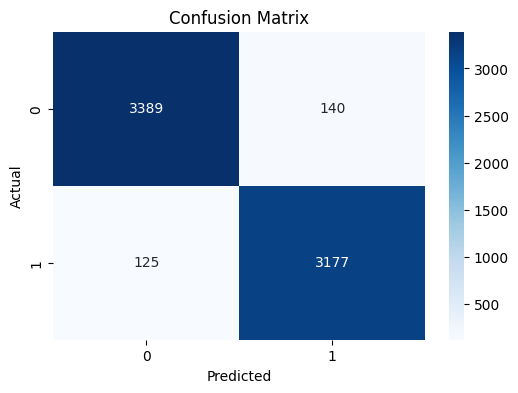

In [20]:
# Accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# F1 Score
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Train Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
Valu

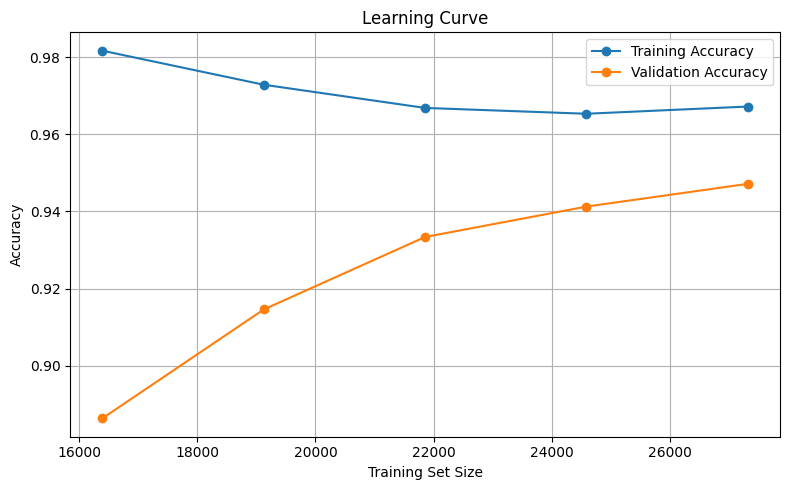

In [21]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Mean scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


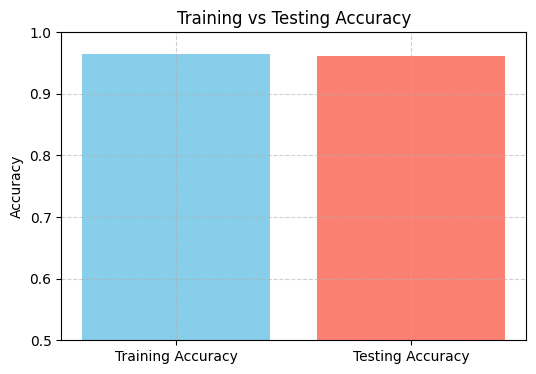

In [22]:
import matplotlib.pyplot as plt

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0.5, 1.0)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#Save the BERT Vectors for Reuse

In [23]:
import pickle

with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(clf, f)


In [24]:
tokenizer.save_pretrained('./distilbert_tokenizer')


('./distilbert_tokenizer/tokenizer_config.json',
 './distilbert_tokenizer/special_tokens_map.json',
 './distilbert_tokenizer/vocab.txt',
 './distilbert_tokenizer/added_tokens.json')

In [25]:
model.save_pretrained('./distilbert_model')


#Summary
The code efficiently processes text data in batches, uses a pre-trained DistilBERT model to understand the context of each word and the overall meaning of each sequence, and extracts the embedding of the [CLS] token as a numerical representation of each text sample. These 768-dimensional vectors (X) then serve as the features for training downstream classifier (the Logistic Regression model in this case).